Running quantum walk solver...
Available backends: ['ibm_brisbane', 'ibm_kyiv', 'ibm_sherbrooke']
Running on real quantum device: ibm_brisbane
Trying direct backend approach...
Error with IBM Quantum: 'Invalid plugin name ibm_dynamic_circuits for stage translation'
Falling back to simulator...
Running on simulator...
Completed run on Local QASM Simulator
Results: {'011000': 1, '001101': 1, '000110': 1, '011011': 1, '011001': 2, '011101': 2}
Path: (1,2) → (1,1) → (0,1) → (0,0) → (1,0) → (2,0) → (1,0) → (1,1) → (1,2) → (2,2)
Highest probability nodes from quantum walk:
(1,2): 37.50%
(0,1): 25.00%
(0,0): 12.50%
(2,0): 12.50%
(1,0): 12.50%


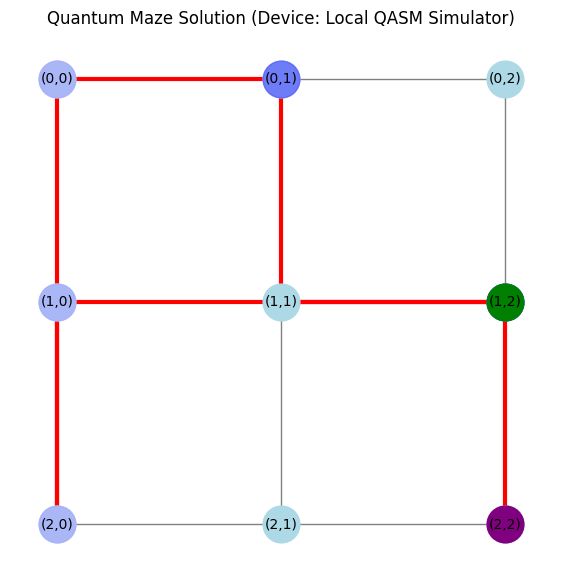

<Figure size 1000x600 with 0 Axes>

In [38]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

def create_maze_graph():
    G = nx.grid_2d_graph(3, 3)
    mapping = {(x, y): f"({x},{y})" for x, y in G.nodes()}
    G = nx.relabel_nodes(G, mapping)
    return G

def get_adjacency_matrix(G):
    nodes = sorted(list(G.nodes()))
    n = len(nodes)
    adjacency_matrix = np.zeros((n, n))
    # Convert node labels to indices
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    # Fill adjacency matrix
    for i, node in enumerate(nodes):
        for neighbor in G.neighbors(node):
            j = node_to_idx[neighbor]
            adjacency_matrix[i, j] = 1
    return adjacency_matrix, nodes

# Quantum Walk Algorithm for maze solving
def quantum_walk_solver(G, steps=3, use_real_device=True, api_token=None):
    # Get adjacency matrix
    adjacency_matrix, nodes = get_adjacency_matrix(G)
    n_nodes = len(nodes)
    n_node_qubits = int(np.ceil(np.log2(n_nodes)))
    n_coin_qubits = 2
    n_qubits = n_node_qubits + n_coin_qubits
    n_classical = n_qubits

    qc = QuantumCircuit(n_qubits, n_classical)
    
    # Initialize position at starting node (0,0) = |000>
    for i in range(n_node_qubits, n_qubits):
        qc.h(i)
        
    # Perform quantum walk steps
    for _ in range(steps):
        for i in range(n_node_qubits, n_qubits):
            qc.h(i)
        qc.x(n_node_qubits)
        qc.x(n_node_qubits + 1)
        qc.ccx(n_node_qubits, n_node_qubits + 1, 0)
        qc.x(n_node_qubits)
        qc.x(n_node_qubits + 1)
        
        qc.x(n_node_qubits)
        qc.ccx(n_node_qubits, n_node_qubits + 1, 0)
        qc.x(n_node_qubits)
        
        qc.x(n_node_qubits + 1)
        qc.ccx(n_node_qubits, n_node_qubits + 1, 1)
        qc.x(n_node_qubits + 1)
        
        qc.ccx(n_node_qubits, n_node_qubits + 1, 1)
        
        qc.h(n_node_qubits)
        qc.p(np.pi / 4, n_node_qubits)
        qc.h(n_node_qubits)
        
    # Apply Quantum Fourier Transform
    qc.append(QFT(n_node_qubits), range(n_node_qubits))
    
    # Measure all qubits
    qc.measure(range(n_qubits), range(n_classical))
    
    shots = 8  
    
    if use_real_device and api_token:
        try:
            # Authenticate to IBM Quantum Runtime Service
            service = QiskitRuntimeService(channel="ibm_quantum", token=api_token)
            
            # Get available backends
            backends = service.backends()
            backend_names = [b.name for b in backends]
            print(f"Available backends: {backend_names}")
            
            # Find a suitable backend (non-simulator with enough qubits)
            backend_name = None
            for b in backends:
                if not b.simulator and b.num_qubits >= n_qubits:
                    backend_name = b.name
                    break
            
            if backend_name:
                print(f"Running on real quantum device: {backend_name}")
                
                try:
                    print("Trying direct backend approach...")
                    # Simple approach: Just use the transpiled circuit directly
                    backend = service.backend(backend_name)
                    
                    # Try to get job_tags attribute to check API version
                    job_tags_exist = hasattr(backend, "run")
                    
                    if job_tags_exist:
                        # For newer Qiskit Runtime
                        transpiled_circuit = transpile(qc, backend=backend)
                        job = backend.run(transpiled_circuit, shots=shots)
                        result = job.result()
                        counts = result.get_counts()
                    else:
                        # Fall back to simulator
                        raise AttributeError("Backend API incompatible")
                        
                    device_used = backend_name
                    
                except Exception as e:
                    print(f"Error with IBM Quantum: {e}")
                    print("Falling back to simulator...")
                    use_real_device = False
            else:
                print("No suitable real quantum device available. Using simulator.")
                use_real_device = False
            
        except Exception as e:
            print(f"Error with IBM Quantum: {e}")
            print("Falling back to simulator...")
            use_real_device = False
    
    # If not using real device (either by choice or due to falling back)
    if not use_real_device:
        print("Running on simulator...")
        # Use the local simulator
        try:
            from qiskit_aer import AerSimulator
            simulator = AerSimulator()
        except ImportError:
            # Fallback for older Qiskit versions
            from qiskit import Aer
            simulator = Aer.get_backend("qasm_simulator")
            
        compiled_circuit = transpile(qc, simulator)
        job = simulator.run(compiled_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts()
        device_used = "Local QASM Simulator"
    
    return counts, qc, nodes, device_used

# Function to interpret quantum walk results
def interpret_quantum_walk(counts, nodes):
    position_counts = {}
    total_shots = 0
    
    for bitstring, count in counts.items():
        # Ensure we get the last 3 bits (position bits) regardless of string format
        position_bits = bitstring[-3:] if len(bitstring) >= 3 else bitstring
        if position_bits in position_counts:
            position_counts[position_bits] += count
        else:
            position_counts[position_bits] = count
        total_shots += count
    
    if total_shots == 0:
        print("Warning: No shots recorded!")
        return []
        
    sorted_positions = sorted(position_counts.items(), key=lambda x: x[1], reverse=True)
    paths = []
    for pos, count in sorted_positions[:5]:
        node_idx = int(pos, 2) if pos else 0
        if node_idx < len(nodes):
            paths.append((nodes[node_idx], count / total_shots * 100))
    return paths

def generate_path_from_quantum_walk(high_prob_nodes, G):
    waypoints = [node for node, _ in high_prob_nodes]
    start_node = "(0,0)"
    end_node = "(2,2)"
    if start_node not in waypoints:
        waypoints.insert(0, start_node)
    if end_node not in waypoints:
        waypoints.append(end_node)
    path = [waypoints[0]]
    for i in range(1, len(waypoints)):
        try:
            segment = nx.shortest_path(G, waypoints[i - 1], waypoints[i])
            path.extend(segment[1:])
        except nx.NetworkXNoPath:
            path.append(waypoints[i])
    return path

def draw_maze(G, path=None, high_prob_nodes=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    pos = {f"({x},{y})": (y, -x) for x in range(3) for y in range(3)}
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=700, font_size=10, ax=ax)
    if high_prob_nodes:
        high_prob_nodes_dict = {node: count for node, count in high_prob_nodes}
        if high_prob_nodes_dict:
            max_count = max(high_prob_nodes_dict.values())
            for node, count in high_prob_nodes:
                intensity = count / max_count
                node_color = (1 - intensity, 1 - intensity, 1)
                nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=[node_color], node_size=700, alpha=0.7, ax=ax)
    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=3, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[path[0]], node_color="green", node_size=700, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[path[-1]], node_color="purple", node_size=700, ax=ax)
    return fig

def main(use_real_device=True, api_token=None, steps=2):
    maze_graph = create_maze_graph()
    print("Running quantum walk solver...")
    counts, qc, nodes, device_used = quantum_walk_solver(maze_graph, steps=steps, use_real_device=use_real_device, api_token=api_token)
    
    print(f"Completed run on {device_used}")
    print("Results:", counts)
    
    high_prob_nodes = interpret_quantum_walk(counts, nodes)
    solution_path = generate_path_from_quantum_walk(high_prob_nodes, maze_graph)
    print("Path:", " → ".join(solution_path))
    
    print("Highest probability nodes from quantum walk:")
    for node, count in high_prob_nodes:
        print(f"{node}: {count:.2f}%")
    
    fig = draw_maze(maze_graph, solution_path, high_prob_nodes)
    plt.title(f"Quantum Maze Solution (Device: {device_used})")
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_histogram(counts, title=f"Measurement Results from {device_used}")
    plt.show()

if __name__ == "__main__":
    
    api_token = "97ec5325d9075880cb41946512f0fa57c7684f2c33a4fc4aa8457ab1a7d79a525b515fcf56ae61092ae7dc030340f8612dd36be75bfa04636fef900fa0af16fa"  # Replace with your actual IBM Quantum API token
    main(use_real_device=True, api_token=api_token, steps=3)